In [76]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap

In [77]:
ts= pd.read_csv('../../data/ts_top100_prediction.csv')

In [78]:
print(ts.shape)
ts.sample(1)

(1739323, 6)


,date,id,item,sales,income,event
1248163,2014-12-20,HOME_&_GARDEN_1_272_NYC_2,HOME_&_GARDEN_1_272,0,0.0,0


In [79]:
ts['date']= pd.to_datetime(ts['date'], format='%Y-%m-%d')

In [80]:
ts['weekday'] = ts['date'].dt.day_name()

In [81]:
ts.sample(5)

,date,id,item,sales,income,event,weekday
895117,2013-12-26,SUPERMARKET_3_455_BOS_1,SUPERMARKET_3_455,11,26.1360,0,Thursday
1396644,2015-05-18,SUPERMARKET_3_252_NYC_2,SUPERMARKET_3_252,8,15.1680,0,Monday
449725,2012-09-05,HOME_&_GARDEN_1_140_PHI_2,HOME_&_GARDEN_1_140,1,18.7125,0,Wednesday
1699037,2016-03-15,HOME_&_GARDEN_1_140_PHI_1,HOME_&_GARDEN_1_140,0,0.0000,0,Tuesday
325814,2012-04-14,SUPERMARKET_2_029_NYC_1,SUPERMARKET_2_029,3,39.5280,0,Saturday


In [82]:
ts = ts[ts['item']=='SUPERMARKET_3_586']

In [83]:
resultados = []

# Copy origina DataFrame
df_original = ts.copy()

dataset = df_original[['item','date','sales','weekday','event']]
df_product = dataset[dataset['item']=='SUPERMARKET_3_586']
df_product_sin_duplicates = df_product[['date','weekday', 'event']].drop_duplicates()
ts_predict = df_product.groupby(['date'])['sales'].sum().reset_index()
ts_predict = ts_predict.merge(df_product_sin_duplicates, on=['date'], how='left')
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.sort_values('date', ascending=True, inplace=True)
ts_predict.set_index('date', inplace=True)
steps = 30
ts_predict = ts_predict.asfreq('D')
y, exog = ts_predict['sales'], ts_predict.drop(columns=['sales'])
y_train, y_test = y[:-steps], y[-steps:]
exog_train, exog_test = exog[:-steps], exog[-steps:]        
forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=123,
                                        max_depth=None,
                                        min_samples_leaf=1, 
                                        min_samples_split=2,
                                        n_estimators=50),
        lags=14
)
     
# Prepare for prediction(next mounth)
start_date = '2016-04-25' 
end_date ='2016-05-30'
# Create range date
date_range = pd.date_range(start=start_date, end=end_date)
# Create DataFrame
df1 = pd.DataFrame(date_range, columns=['date'])
df1['date'] = pd.to_datetime(df1['date'])
df1['weekday'] = df1['date'].dt.day_name()
df1['event'] = 0
df1 = pd.get_dummies(data=df1, columns=['weekday'], dtype=int)
df1.sort_values('date', inplace=True, ascending=True)
df1.set_index('date', inplace=True)
df1 = df1.asfreq('D')
exog_test = pd.concat([exog_test, df1], ignore_index=False)
forecaster.fit(y=y_train, exog=exog_train)
predictions = forecaster.predict(steps=30, exog=exog_test).to_list()
resultados.append({'prediction':predictions,'test':y_test.values})

In [84]:
pd.DataFrame(resultados)

,prediction,test
0,"[521.26, 530.9, 359.82, 364.9, 363.08, 405.74,...","[635, 579, 339, 290, 300, 332, 405, 485, 506, ..."


In [85]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")
rmspe = np.sqrt(np.mean(((y_test - predictions) / y_test) ** 2)) * 100

Test error (MSE): 2326.335706666666


In [86]:
result = pd.DataFrame(predictions, columns=['prediction'])

In [87]:
result['date'] = pd.DataFrame(list(y_test.index.values))

In [88]:
result.set_index('date', inplace=True)

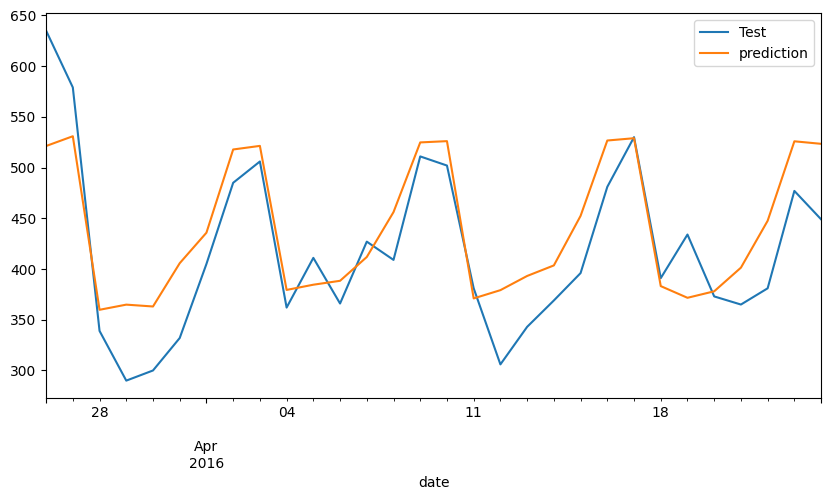

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))
y_test[-30:].plot(ax=ax, label='Test')
result.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()